In [1]:
import json
from collections import defaultdict
import math

def get_acc(path):
    items = []
    id_counts = defaultdict(int)
    
    # First pass: read + count _id occurrences
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line)
            items.append(obj)
            if "_id" in obj:
                id_counts[obj["_id"]] += 1
    
    # Filter: remove ALL duplicated _id items
    filtered = []
    for obj in items:
        _id = obj.get("_id")
        if _id is None or id_counts[_id] == 1:
            filtered.append(obj)
    
    # Recompute counts
    counts = defaultdict(int)
    correct = defaultdict(int)
    nulls = 0
    
    for x in filtered:
        key = (x["difficulty"], x["length"])
        counts[key] += 1
        if x["judge"] is True:
            correct[key] += 1
        if not x["pred"]:
            nulls+=1
    
    # Print table
    for diff in ["easy", "hard"]:
        for length in ["short", "medium", "long"]:
            k = (diff, length)
            if counts[k] == 0:
                acc = float("nan")
            else:
                acc = correct[k] / counts[k]
            print(
                f"difficulty={diff:4s} length={length:6s} "
                f"acc={acc:.4f} ({correct[k]}/{counts[k]})"
            )
    
    # Overall accuracy
    total = sum(counts.values())
    total_correct = sum(correct.values())
    
    print(f"OVERALL acc={total_correct/total:.4f} ({total_correct}/{total})")
    print(f"Bad Answer Format acc={nulls/total:.4f} ({nulls}/{total})")
    
    # Null baseline (random guessing, 4-way MC)
    null_acc = 0.25
    print(f"Baseline acc={null_acc:.4f} ({null_acc * total:.1f}/{total})")

from pathlib import Path
paths = Path(".").glob("*.jsonl")
res = []
for path in paths:
    res.append(path)
res.sort()


for path in res:
    print(path.name)
    get_acc(path.name)
    print()



Llama-3.1-8B-Instruct__ctx131072__rep1.jsonl
difficulty=easy length=short  acc=0.4138 (24/58)
difficulty=easy length=medium acc=0.2500 (22/88)
difficulty=easy length=long   acc=0.2889 (13/45)
difficulty=hard length=short  acc=0.3306 (40/121)
difficulty=hard length=medium acc=0.2756 (35/127)
difficulty=hard length=long   acc=0.3443 (21/61)
OVERALL acc=0.3100 (155/500)
Bad Answer Format acc=0.0040 (2/500)
Baseline acc=0.2500 (125.0/500)

Llama-3.1-8B-Instruct__ctx65536__rep1.jsonl
difficulty=easy length=short  acc=0.4068 (24/59)
difficulty=easy length=medium acc=0.2841 (25/88)
difficulty=easy length=long   acc=0.2444 (11/45)
difficulty=hard length=short  acc=0.3471 (42/121)
difficulty=hard length=medium acc=0.2992 (38/127)
difficulty=hard length=long   acc=0.2857 (18/63)
OVERALL acc=0.3141 (158/503)
Bad Answer Format acc=0.0179 (9/503)
Baseline acc=0.2500 (125.8/503)

Llama-3.1-8B-Instruct__ctx8192__rep1.jsonl
difficulty=easy length=short  acc=0.5000 (29/58)
difficulty=easy length=medium

In [2]:
from pathlib import Path
paths = Path(".").glob("*.jsonl")
res = []
for path in paths:
    res.append(path)
res.sort()


for path in res:
    print(path.name)
    get_acc(path.name)
    print()



Llama-3.1-8B-Instruct__ctx131072__rep1.jsonl
difficulty=easy length=short  acc=0.4138 (24/58)
difficulty=easy length=medium acc=0.2500 (22/88)
difficulty=easy length=long   acc=0.2889 (13/45)
difficulty=hard length=short  acc=0.3306 (40/121)
difficulty=hard length=medium acc=0.2756 (35/127)
difficulty=hard length=long   acc=0.3443 (21/61)
OVERALL acc=0.3100 (155/500)
Bad Answer Format acc=0.0040 (2/500)
Baseline acc=0.2500 (125.0/500)

Llama-3.1-8B-Instruct__ctx65536__rep1.jsonl
difficulty=easy length=short  acc=0.4068 (24/59)
difficulty=easy length=medium acc=0.2841 (25/88)
difficulty=easy length=long   acc=0.2444 (11/45)
difficulty=hard length=short  acc=0.3471 (42/121)
difficulty=hard length=medium acc=0.2992 (38/127)
difficulty=hard length=long   acc=0.2857 (18/63)
OVERALL acc=0.3141 (158/503)
Bad Answer Format acc=0.0179 (9/503)
Baseline acc=0.2500 (125.8/503)

Llama-3.1-8B-Instruct__ctx8192__rep1.jsonl
difficulty=easy length=short  acc=0.5000 (29/58)
difficulty=easy length=medium

In [31]:
import json
from collections import defaultdict, Counter
import math

LETTERS = ["A", "B", "C", "D"]

def _chisq_vs_uniform(counts: Counter) -> float:
    """Pearson chi-square vs uniform over A/B/C/D (ignores missing letters)."""
    n = sum(counts.get(L, 0) for L in LETTERS)
    if n == 0:
        return float("nan")
    exp = n / 4.0
    return sum(((counts.get(L, 0) - exp) ** 2) / exp for L in LETTERS)

def _kl_to_uniform(counts: Counter) -> float:
    """KL(P||U) in nats; 0 means perfectly uniform."""
    n = sum(counts.get(L, 0) for L in LETTERS)
    if n == 0:
        return float("nan")
    kl = 0.0
    for L in LETTERS:
        p = counts.get(L, 0) / n
        if p > 0:
            kl += p * math.log(p / 0.25)
    return kl

def _entropy_bits(counts: Counter) -> float:
    """Entropy in bits; max is 2 bits for uniform over 4 letters."""
    n = sum(counts.get(L, 0) for L in LETTERS)
    if n == 0:
        return float("nan")
    H = 0.0
    for L in LETTERS:
        p = counts.get(L, 0) / n
        if p > 0:
            H -= p * math.log2(p)
    return H

def analyze_letter_skew(path: str, drop_duplicate_ids: bool = True):
    items = []
    id_counts = defaultdict(int)

    # Read + count _id occurrences
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line)
            items.append(obj)
            if "_id" in obj:
                id_counts[obj["_id"]] += 1

    # Filter: remove ALL duplicated _id items (same rule as your get_acc)
    if drop_duplicate_ids:
        filtered = []
        for obj in items:
            _id = obj.get("_id")
            if _id is None or id_counts[_id] == 1:
                filtered.append(obj)
    else:
        filtered = items

    # Counters
    pred_all = Counter()
    pred_correct = Counter()
    pred_wrong = Counter()
    pred_null = 0

    gold_all = Counter()

    # Breakdown by (difficulty, length)
    pred_by_group = defaultdict(Counter)
    gold_by_group = defaultdict(Counter)
    n_by_group = defaultdict(int)
    null_by_group = defaultdict(int)

    for x in filtered:
        diff = x.get("difficulty", "unknown")
        length = x.get("length", "unknown")
        gkey = (diff, length)

        gold = (x.get("answer") or "").strip().upper()
        pred = (x.get("pred") or "").strip().upper()
        judge = bool(x.get("judge", False))

        if gold in LETTERS:
            gold_all[gold] += 1
            gold_by_group[gkey][gold] += 1

        if pred in LETTERS:
            pred_all[pred] += 1
            pred_by_group[gkey][pred] += 1
            n_by_group[gkey] += 1
            if judge:
                pred_correct[pred] += 1
            else:
                pred_wrong[pred] += 1
        else:
            pred_null += 1
            null_by_group[gkey] += 1

    def _print_dist(title: str, c: Counter):
        n = sum(c.get(L, 0) for L in LETTERS)
        if n == 0:
            print(f"{title}: (no valid A/B/C/D preds)")
            return
        parts = [f"{L}:{c.get(L,0)} ({c.get(L,0)/n:.2%})" for L in LETTERS]
        print(f"{title}: n={n} | " + "  ".join(parts))
        print(f"  chi^2 vs uniform: {_chisq_vs_uniform(c):.2f} (df=3)")
        print(f"  KL(P||U): {_kl_to_uniform(c):.4f} nats")
        print(f"  entropy: {_entropy_bits(c):.4f} bits (max 2.0000)")

    print(f"File: {path}")
    print(f"Total items read: {len(items)}")
    print(f"After duplicate _id filtering: {len(filtered)}")
    print(f"Null/invalid pred count: {pred_null} ({pred_null/max(1,len(filtered)):.2%})")
    print()

    # Overall distributions
    _print_dist("Pred distribution (ALL valid preds)", pred_all)
    print()
    _print_dist("Pred distribution (CORRECT only)", pred_correct)
    print()
    _print_dist("Pred distribution (WRONG only)", pred_wrong)
    print()

    # Compare to gold label distribution (helps detect dataset imbalance vs model bias)
    _print_dist("Gold answer distribution", gold_all)
    print()

    # Grouped view (difficulty x length)
    print("By (difficulty, length) group (valid preds only):")
    for diff in ["easy", "hard"]:
        for length in ["short", "medium", "long"]:
            gkey = (diff, length)
            c = pred_by_group[gkey]
            n = sum(c.get(L, 0) for L in LETTERS)
            if n == 0 and null_by_group[gkey] == 0:
                continue
            parts = [f"{L}:{c.get(L,0)}" for L in LETTERS]
            print(
                f"  {diff:4s}/{length:6s}  n_valid={n:5d}  null={null_by_group[gkey]:5d}  "
                + " ".join(parts)
                + (f"  chi^2={_chisq_vs_uniform(c):.2f}" if n > 0 else "")
            )

    # Optional: find “most biased” letter (overall)
    n_all = sum(pred_all.get(L, 0) for L in LETTERS)
    if n_all > 0:
        top = max(LETTERS, key=lambda L: pred_all.get(L, 0))
        print()
        print(f"Most common predicted letter: {top} ({pred_all[top]/n_all:.2%} of valid preds)")


In [32]:
from pathlib import Path
paths = Path(".").glob("*.jsonl")
res = []
for path in paths:
    res.append(path)
res.sort()


for path in res:
    print(path.name)
    analyze_letter_skew(path)
    print()


Llama-3.1-8B-Instruct__ctx131072__rep1.jsonl
File: Llama-3.1-8B-Instruct__ctx131072__rep1.jsonl
Total items read: 506
After duplicate _id filtering: 500
Null/invalid pred count: 2 (0.40%)

Pred distribution (ALL valid preds): n=498 | A:93 (18.67%)  B:143 (28.71%)  C:114 (22.89%)  D:148 (29.72%)
  chi^2 vs uniform: 16.04 (df=3)
  KL(P||U): 0.0165 nats
  entropy: 1.9762 bits (max 2.0000)

Pred distribution (CORRECT only): n=155 | A:22 (14.19%)  B:39 (25.16%)  C:42 (27.10%)  D:52 (33.55%)
  chi^2 vs uniform: 12.05 (df=3)
  KL(P||U): 0.0418 nats
  entropy: 1.9397 bits (max 2.0000)

Pred distribution (WRONG only): n=343 | A:71 (20.70%)  B:104 (30.32%)  C:72 (20.99%)  D:96 (27.99%)
  chi^2 vs uniform: 9.85 (df=3)
  KL(P||U): 0.0143 nats
  entropy: 1.9793 bits (max 2.0000)

Gold answer distribution: n=500 | A:96 (19.20%)  B:127 (25.40%)  C:148 (29.60%)  D:129 (25.80%)
  chi^2 vs uniform: 11.12 (df=3)
  KL(P||U): 0.0115 nats
  entropy: 1.9835 bits (max 2.0000)

By (difficulty, length) group (v

                                        file                 model  context_len      acc  null_rate  total
  Llama-3.1-8B-Instruct__ctx8192__rep1.jsonl Llama-3.1-8B-Instruct         8192 0.317814   0.010121    494
 Llama-3.1-8B-Instruct__ctx65536__rep1.jsonl Llama-3.1-8B-Instruct        65536 0.314115   0.017893    503
Llama-3.1-8B-Instruct__ctx131072__rep1.jsonl Llama-3.1-8B-Instruct       131072 0.310000   0.004000    500
    Qwen2.5-7B-Instruct__ctx8192__rep1.jsonl   Qwen2.5-7B-Instruct         8192 0.293011   0.000000    372
   Qwen2.5-7B-Instruct__ctx16384__rep1.jsonl   Qwen2.5-7B-Instruct        16384 0.296223   0.019881    503
  Qwen2.5-7B-Instruct__ctx131072__rep1.jsonl   Qwen2.5-7B-Instruct       131072 0.339321   0.007984    501
     mamba-codestral-7b__ctx8192__rep1.jsonl    mamba-codestral-7b         8192 0.250497   0.009940    503
    mamba-codestral-7b__ctx65536__rep1.jsonl    mamba-codestral-7b        65536 0.234592   0.015905    503
   mamba-codestral-7b__ctx131072__rep

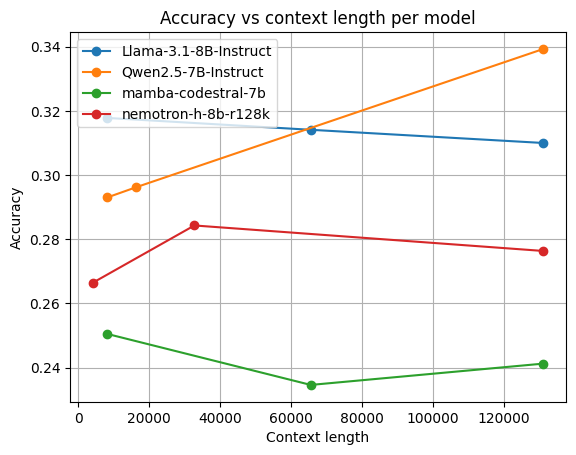

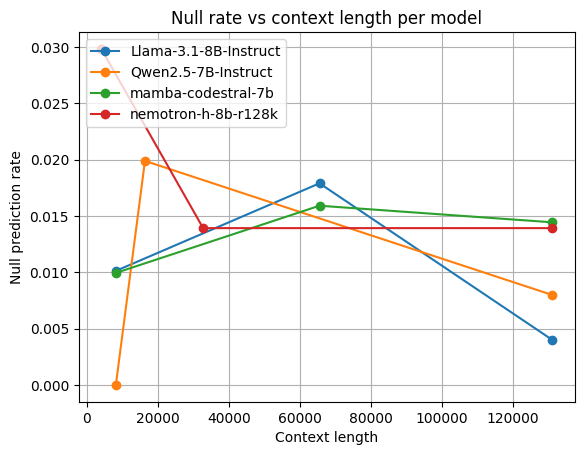

In [13]:
import json, re
from pathlib import Path
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

def summarize_jsonl(path: Path):
    id_counts = defaultdict(int)
    items = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue
            obj = json.loads(line)
            items.append(obj)
            _id = obj.get("_id")
            if _id is not None:
                id_counts[_id] += 1

    filtered = []
    for obj in items:
        _id = obj.get("_id")
        if _id is None or id_counts[_id] == 1:
            filtered.append(obj)

    total = len(filtered)
    if total == 0:
        return {"total": 0, "correct": 0, "acc": float("nan"), "nulls": 0, "null_rate": float("nan")}

    correct = 0
    nulls = 0
    for x in filtered:
        if x.get("judge") is True:
            correct += 1
        pred = x.get("pred")
        if pred is None or (isinstance(pred, str) and pred.strip() == ""):
            nulls += 1

    return {"total": total, "correct": correct, "acc": correct / total, "nulls": nulls, "null_rate": nulls / total}

import re

def infer_model_and_ctx(filename: str):
    """
    Handles filenames like:
      Llama-3.1-8B-Instruct__ctx131072__rep1.jsonl
      nemotron-h-8b-r128k__ctx4096__rep1.jsonl
      Qwen2.5-7B-Instruct__ctx16384__rep1.jsonl
    """
    # 1) Extract ctx length from __ctx####__
    m = re.search(r"__ctx(\d+)__", filename, flags=re.IGNORECASE)
    ctx = int(m.group(1)) if m else None

    # 2) Normalize common "k-ish" values (optional but keeps plots consistent)
    if ctx in (4000, 4096): ctx = 4096
    if ctx in (8000, 8192): ctx = 8192
    if ctx in (16000, 16384): ctx = 16384
    if ctx in (32000, 32768): ctx = 32768
    if ctx in (64000, 65536): ctx = 65536
    if ctx in (128000, 131072): ctx = 131072

    # 3) Model name = everything before __ctx
    model = re.sub(r"__ctx\d+__.*$", "", filename, flags=re.IGNORECASE)
    model = re.sub(r"\.jsonl$", "", model, flags=re.IGNORECASE)

    return model, ctx


def main():
    files = sorted(Path(".").glob("*.jsonl"))
    if not files:
        raise SystemExit("No *.jsonl found in current directory.")

    rows = []
    for p in files:
        summ = summarize_jsonl(p)
        model, ctx = infer_model_and_ctx(p.name)
        rows.append({"file": p.name, "model": model, "context_len": ctx, **summ})

    df = pd.DataFrame(rows).dropna(subset=["context_len"])
    df["context_len"] = df["context_len"].astype(int)
    df = df.sort_values(["model", "context_len", "file"])

    print(df[["file","model","context_len","acc","null_rate","total"]].to_string(index=False))

    # Aggregate if multiple runs per (model, context)
    agg = (df.groupby(["model","context_len"], as_index=False)
             .agg(acc=("acc","mean"), null_rate=("null_rate","mean"), total=("total","sum")))
    agg = agg.sort_values(["model","context_len"])

    # Plot acc
    plt.figure()
    for model, g in agg.groupby("model"):
        plt.plot(g["context_len"], g["acc"], marker="o", label=model)
    plt.xlabel("Context length")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs context length per model")
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.show()

    # Plot null rate
    plt.figure()
    for model, g in agg.groupby("model"):
        plt.plot(g["context_len"], g["null_rate"], marker="o", label=model)
    plt.xlabel("Context length")
    plt.ylabel("Null prediction rate")
    plt.title("Null rate vs context length per model")
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.show()

if __name__ == "__main__":
    main()


In [10]:
!ls


Comp
Llama-3.1-8B-Instruct__ctx131072__rep1.jsonl
Llama-3.1-8B-Instruct__ctx65536__rep1.jsonl
Llama-3.1-8B-Instruct__ctx8192__rep1.jsonl
mamba-codestral-7b__ctx131072__rep1.jsonl
mamba-codestral-7b__ctx65536__rep1.jsonl
mamba-codestral-7b__ctx8192__rep1.jsonl
nemotron-h-8b-r128k__ctx131072__rep1.jsonl
nemotron-h-8b-r128k__ctx32768__rep1.jsonl
nemotron-h-8b-r128k__ctx4096__rep1.jsonl
Qwen2.5-7B-Instruct__ctx131072__rep1.jsonl
Qwen2.5-7B-Instruct__ctx16384__rep1.jsonl
Qwen2.5-7B-Instruct__ctx8192__rep1.jsonl
view.ipynb
